<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter10SamplingStrategy/MultiframeImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimation of moving objects from exposure sequences
## David Brady
## University of Arizona
## May 2025

We consider estimation of an image $f$ from a sequence of exposures. To compensate for object motion between exposures, we transform the sequence into a set of coded planes, which are then processed by a neural estimator to recover the original object. Encoding and decoding is necessary because the data processing system lacks the capacity to estimate the scene from the full original sequence.

## libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu
from IPython.display import display, clear_output
import ipywidgets as widgets
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})

## Object motion model

As example objects we use the MNIST digits. Each digit is randomly placed in a N by N pixel grid and moves linearly in a random direction over F frames.

In [3]:

# Re-including the generate_noisy_digit_motion function for a self-contained applet
def generate_noisy_digit_motion(
    digit_image=None,
    frame_size=(96, 96),
    num_frames=40,
    noise_scale_factor=100
):
    """
    Generates a sequence of frames showing an MNIST-like digit moving with
    Poisson noise.

    Args:
        digit_image (np.ndarray, optional): A 2D numpy array representing the
            digit (e.g., 28x28). Pixel values should be between 0 and 1.
            If None, a placeholder square digit will be used.
        frame_size (tuple): The (height, width) of the output frames.
        num_frames (int): The number of frames in the sequence.
        noise_scale_factor (float): A factor to scale pixel intensities before
            applying Poisson noise. Higher values result in less apparent noise.
            This effectively sets the mean of the Poisson distribution for
            each pixel.

    Returns:
        np.ndarray: A 3D numpy array of shape (num_frames, frame_height, frame_width)
            containing the sequence of noisy frames. Pixel values are between 0 and 1.
        and a 2D numpy array describing the start position of the digit.
    """
    frame_height, frame_width = frame_size

    # --- Digit Initialization ---
    if digit_image is None:
        digit_height, digit_width = 28, 28
        digit_image = np.zeros((digit_height, digit_width), dtype=np.float32)
        digit_image[5:23, 5:23] = 1.0 # Placeholder white square
    else:
        digit_height, digit_width = digit_image.shape
        digit_image = digit_image.astype(np.float32)
        if digit_image.max() > 1.0:
            digit_image /= digit_image.max()

    if digit_width > frame_width or digit_height > frame_height:
        raise ValueError(
            f"Digit dimensions ({digit_width}x{digit_height}) are larger than "
            f"frame dimensions ({frame_width}x{frame_height})."
        )
    initialPositions=np.zeros((num_frames,2),dtype=np.int8)

    # --- Initial Position Calculation ---
    # keep it in the middle
    max_start_x = frame_width/2
    max_start_y = frame_height/2

    start_x = np.random.randint(frame_width/4, max_start_x + 1)
    start_y = np.random.randint(frame_width/4, max_start_y + 1)
    initialPositions[0,0]=start_x
    initialPositions[0,1]=start_y

    current_x = float(start_x)
    current_y = float(start_y)

    # --- Velocity Calculation ---
    velocity_magnitude = np.random.uniform(0, .5)
    velocity_angle = np.random.uniform(0, 2 * np.pi)

    vx = velocity_magnitude * np.cos(velocity_angle)
    vy = velocity_magnitude * np.sin(velocity_angle)

    # --- Frame Generation Loop ---
    frames = np.zeros((num_frames, frame_height, frame_width), dtype=np.float32)

    for i in range(num_frames):
        frame = np.zeros(frame_size, dtype=np.float32)

        digit_pos_x = int(round(current_x))
        digit_pos_y = int(round(current_y))

        clip_x_start = max(0, digit_pos_x)
        clip_y_start = max(0, digit_pos_y)
        clip_x_end = min(frame_width, digit_pos_x + digit_width)
        clip_y_end = min(frame_height, digit_pos_y + digit_height)

        digit_clip_x_start = max(0, -digit_pos_x)
        digit_clip_y_start = max(0, -digit_pos_y)
        digit_clip_x_end = digit_width - max(0, (digit_pos_x + digit_width) - frame_width)
        digit_clip_y_end = digit_height - max(0, (digit_pos_y + digit_height) - frame_height)

        if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
            digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
            frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
                digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

        # --- Add Poisson Noise ---
        noisy_frame = np.random.poisson(frame * noise_scale_factor) / noise_scale_factor
        noisy_frame = np.clip(noisy_frame, 0.0, 1.0)

        frames[i] = noisy_frame

        # --- Update Position for Next Frame ---
        current_x += vx
        current_y += vy

    return frames, initialPositions


def create_digit_motion_applet(frames=None):
    """
    Creates an interactive display for a sequence of noisy digit motion frames
    suitable for a Jupyter/Colab notebook environment.

    Args:
        digit_image (np.ndarray, optional): A 2D numpy array representing the
            digit (e.g., 28x28). If None, a placeholder square digit will be used.
    """
    # Generate the frames using the previously defined function
    if frames is None:
      frames = generate_noisy_digit_motion()[0]
    num_frames = frames.shape[0]

    # Set up the plot for inline display
    fig, ax = plt.subplots(figsize=(8, 8))
    # Display the initial frame
    image_display = ax.imshow(frames[0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Frame 1 / {num_frames}")
    ax.axis('off') # Hide axes ticks and labels
    plt.close(fig) # Prevent matplotlib from displaying the figure immediately

    # Create the ipywidgets slider
    frame_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=num_frames - 1,
        step=1,
        description='Frame:',
        continuous_update=True, # Update as slider is dragged
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    # Create an output widget to hold the plot
    output = widgets.Output()

    # Define the update function for the slider
    def update_plot(change):
        with output:
            clear_output(wait=True) # Clear previous plot
            frame_idx = change['new'] # Get the new value from the slider change event
            image_display.set_data(frames[frame_idx]) # Update the image data
            ax.set_title(f"Frame {frame_idx + 1} / {num_frames}") # Update the title
            display(fig) # Display the updated figure

    # Register the update function to be called when the slider value changes
    frame_slider.observe(update_plot, names='value')

    # Initial display of the plot
    with output:
        display(fig)

    # Display the slider and the output plot together in a VBox
    display(widgets.VBox([frame_slider, output]))



In [3]:
simulated_mnist_digit = np.zeros((28, 28), dtype=np.float32)
simulated_mnist_digit[5:8, 5:23] = 1.0
simulated_mnist_digit[5:23, 20:23] = 1.0
simulated_mnist_digit[20:23, 5:23] = 0.5
create_digit_motion_applet(generate_noisy_digit_motion(simulated_mnist_digit)[0])

## Encoding strategy

This code simulates a compressive projection process for video data, where each frame is encoded onto two data planes using a shifting binary (1/-1) pattern.

The primary goal of this script is to demonstrate how a video, consisting of multiple frames, can be "compressed" into two static data planes. Each pixel from a video frame contributes to one of the two data planes based on a corresponding value in a dynamically shifting code pattern.

How it Works
* Video and Code Initialization:

  * The script takes a 3D NumPy array as video_data (frames, height, width) and a 2D NumPy array as initial_code (height, width).
  *  The initial_code is a pattern of 1s and -1s.

* Frame-by-Frame Processing:

  * The code iterates through each frame of the input video.
  * For each frame, it applies the current_code pattern.
  * If a pixel in the current_code is 1, the corresponding pixel from the video frame is added to data_plane_1.
  * If a pixel in the current_code is -1, the corresponding pixel from the video frame is added to data_plane_2.

* Cyclic Code Shifting:

  * After processing each frame, the current_code is shifted horizontally by one pixel to the right.
  * This shift is cyclic, meaning pixels shifted off the right edge reappear on the left edge. This ensures the 64x64 code pattern is always present and wraps around. The rule code(x,y, t+1) = code(x-1,y,t) is implemented using np.roll(current_code, shift=1, axis=1).

* Output:

  * The function returns the two accumulated data planes (data_plane_1 and data_plane_2).
.

In [4]:

def generate_coded_data_planes(video_data, initial_code):
    """
    Generates two data planes by applying a shifting coded pattern
    to each frame of a video.

    Args:
        video_data (np.ndarray): A 3D NumPy array representing the video.
                                 Shape: (num_frames, height, width).
                                 Each frame is a 64x64 image.
        initial_code (np.ndarray): A 2D NumPy array representing the initial
                                   64x64 coded pattern with values 1 and -1.

    Returns:
        tuple: A tuple containing two 2D NumPy arrays:
               - data_plane_1 (np.ndarray): Accumulated pixel values where code was 1.
               - data_plane_2 (np.ndarray): Accumulated pixel values where code was -1.
    """
    num_frames, height, width = video_data.shape

    # Ensure the initial code matches the frame dimensions
    if initial_code.shape != (height, width):
        raise ValueError(f"Initial code shape must be {height}x{width}, but got {initial_code.shape}")
    if not np.all(np.isin(initial_code, [1, -1])):
        raise ValueError("Initial code must only contain values 1 and -1.")

    # Initialize the two 64x64 data planes with zeros
    data_plane_1 = np.zeros((height, width), dtype=float)
    data_plane_2 = np.zeros((height, width), dtype=float)

    # Make a copy of the initial code to shift it across frames
    current_code = np.copy(initial_code)

    print(f"Processing {num_frames} frames...")

    for t in range(num_frames):
        # Get the current frame
        frame = video_data[t, :, :]

        # Create masks for where the code is 1 and -1
        mask_code_1 = (current_code == 1)
        mask_code_neg_1 = (current_code == -1)

        # Add image pixels to the corresponding data planes
        # Where code is 1, add pixel to data_plane_1
        data_plane_1[mask_code_1] += frame[mask_code_1]
        # Where code is -1, add pixel to data_plane_2
        data_plane_2[mask_code_neg_1] += frame[mask_code_neg_1]

        # Shift the code cyclically by one pixel in the horizontal axis for the next frame
        # code(x,y, t+1) = code(x-1,y,t)
        # This means shifting columns to the right by 1, with wrap-around.
        # np.roll(array, shift, axis)
        # A positive shift means elements are shifted to the right (or down).
        # So, to get code(x-1) into code(x), we need to shift by +1.
        current_code = np.roll(current_code, shift=1, axis=1)

        # Optional: Print progress
        if (t + 1) % 5 == 0 or t == num_frames - 1:
            print(f"  Processed frame {t + 1}/{num_frames}")

    return data_plane_1, data_plane_2





In [5]:
video_data = generate_noisy_digit_motion()[0]
height, width = 96, 96
# 3. Generate an initial 64x64 code with values 1 and -1
# We'll randomly assign 1 or -1 to each position.
initial_code = np.random.choice([1, -1], size=(height, width))
print(f"Generated initial code with shape: {initial_code.shape}")

# 4. Generate the coded data planes
try:
    dp1, dp2 = generate_coded_data_planes(video_data, initial_code)

    print("\n--- Results ---")
    print(f"Shape of Data Plane 1: {dp1.shape}")
    print(f"Shape of Data Plane 2: {dp2.shape}")

    # Optional: Print a small part of the data planes to verify
    # print("\nFirst 5x5 block of Data Plane 1:")
    # print(dp1[:5, :5])
    # print("\nFirst 5x5 block of Data Plane 2:")
    # print(dp2[:5, :5])

except ValueError as e:
    print(f"Error: {e}")



Generated initial code with shape: (96, 96)
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40

--- Results ---
Shape of Data Plane 1: (96, 96)
Shape of Data Plane 2: (96, 96)


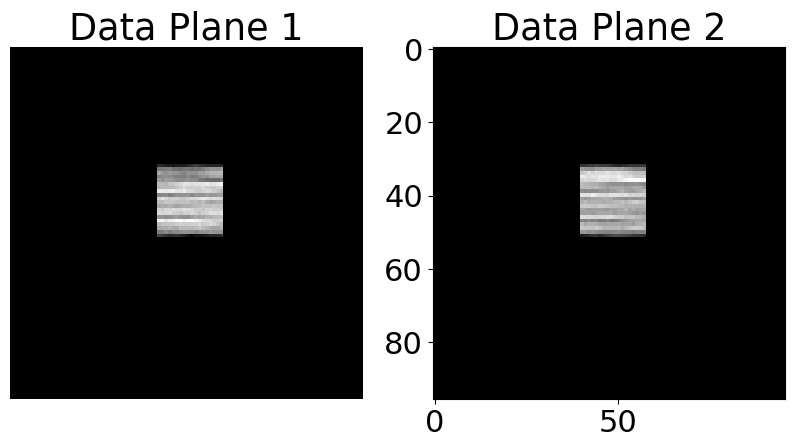

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dp1, cmap='gray')
plt.title('Data Plane 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dp2, cmap='gray')
plt.title('Data Plane 2')
plt.show()

## Code

As an example code, we use an 8 by 8 random matrix, tiled in an 8 by 8 grid to produce a 64 by 64 element grid

<ipython-input-6-6130ae9971d7>:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  baseCode=np.random.random_integers(0,1,size=(8,8 ))


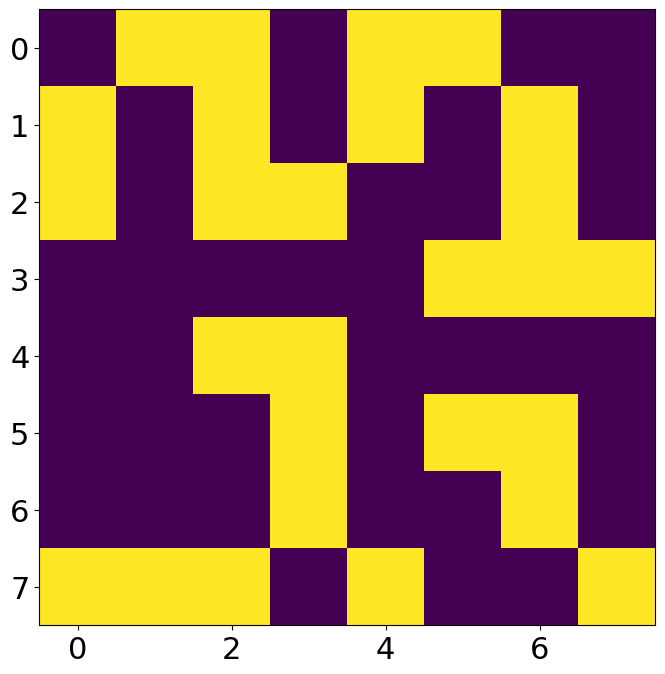

In [6]:
baseCode=np.random.random_integers(0,1,size=(8,8 ))
baseCode=baseCode*2-1
plt.figure(figsize=(8, 8))
plt.imshow(baseCode)

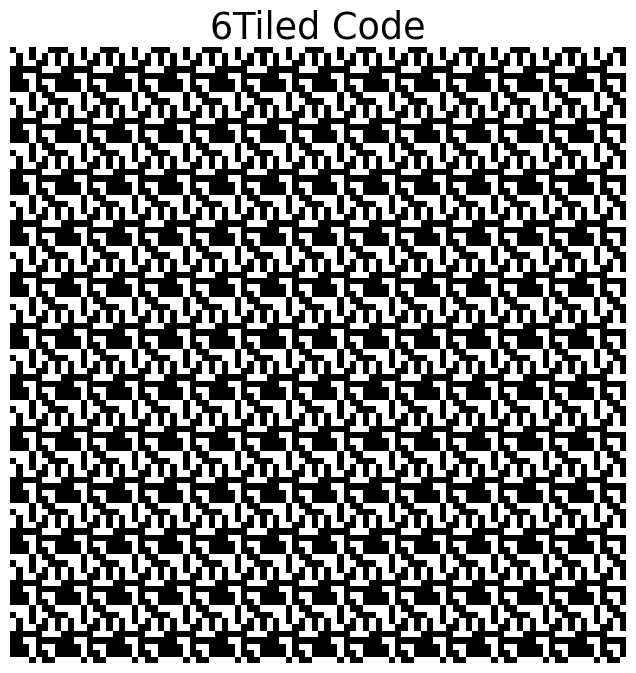

Using tiled code with shape: (96, 96) as initial_code.
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40

--- Results ---
Shape of Data Plane 1: (96, 96)
Shape of Data Plane 2: (96, 96)


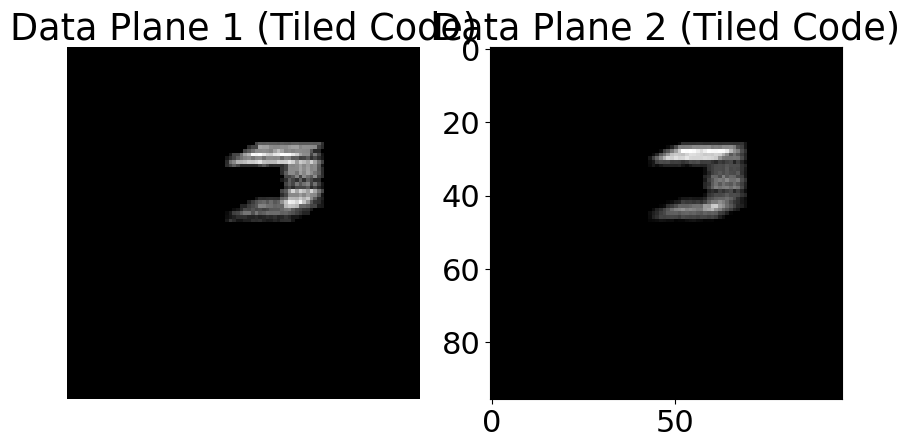

In [7]:

# Create the tiled array
tiled_code = np.tile(baseCode, (12, 12))

# Display the tiled code
plt.figure(figsize=(8, 8))
plt.imshow(tiled_code, cmap='gray', vmin=-1, vmax=1)
plt.title('6Tiled Code')
plt.axis('off')
plt.show()

# Use the tiled code as the initial code for generating data planes
initial_code = tiled_code
print(f"Using tiled code with shape: {initial_code.shape} as initial_code.")


simulated_mnist_digit = np.zeros((28, 28), dtype=np.float32)
simulated_mnist_digit[5:8, 5:23] = 1.0
simulated_mnist_digit[5:23, 20:23] = 1.0
simulated_mnist_digit[20:23, 5:23] = 0.5
video_data = generate_noisy_digit_motion(simulated_mnist_digit)[0]


# 4. Generate the coded data planes using the tiled code
try:
    dp1, dp2 = generate_coded_data_planes(video_data, initial_code)

    print("\n--- Results ---")
    print(f"Shape of Data Plane 1: {dp1.shape}")
    print(f"Shape of Data Plane 2: {dp2.shape}")

    # Display the resulting data planes
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(dp1, cmap='gray')
    plt.title('Data Plane 1 (Tiled Code)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dp2, cmap='gray')
    plt.title('Data Plane 2 (Tiled Code)')
    plt.show()

except ValueError as e:
    print(f"Error: {e}")
except NameError:
    print("Error: 'video_data' is not defined. Please run the cell that generates video_data first.")


## Create training data

Streaming output truncated to the last 5000 lines.
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame

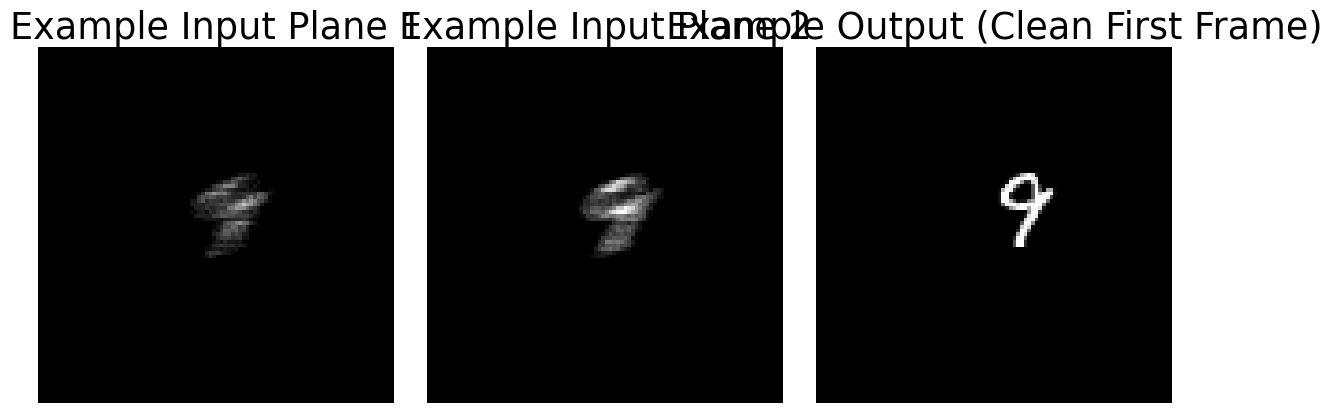

In [24]:
# prompt: load the MNIST data set of handdrawn digits. Use a randomly selected set of 10000 digits to generate trainin




# Load the MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Select a random set of 2500 digits
num_samples = 10000
noise_factor=5
random_indices = np.random.choice(len(mnist_train_images), num_samples, replace=False)
selected_digits = mnist_train_images[random_indices]

# Initialize lists to store training data
X_train = []
y_train = []

print(f"Generating {num_samples} training examples...")

# Generate training input-output pairs
for i, digit_image in enumerate(selected_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40, noise_scale_factor=noise_factor)

    # Generate the encoded input (coded frames)
    # We need an initial code. Let's reuse the tiled code or generate a new random one.
    # Using the tiled code from the previous section if it exists, otherwise generate a random one
    if 'tiled_code' in locals():
        initial_code = tiled_code
    else:
        initial_code = np.random.choice([1, -1], size=(96, 96))


    dp1, dp2 = generate_coded_data_planes(video_stack, initial_code)
    # Concatenate the two data planes to form the input features
    # Shape will be (height, width, 2)
    encoded_input = np.stack([dp1, dp2], axis=-1)

    # Normalize the encoded input to be between 0 and 1
    # Find min and max values across both planes for normalization
    min_val = np.min(encoded_input)
    max_val = np.max(encoded_input)
    if max_val - min_val > 1e-6: # Avoid division by zero or near-zero
      normalized_encoded_input = (encoded_input - min_val) / (max_val - min_val)
    else:
      normalized_encoded_input = np.zeros_like(encoded_input) # Handle case where all values are the same


    # Generate the output (uncorrupted first frame)
    # The uncorrupted first frame can be reconstructed using the original digit image
    # and the start position [0] from generate_noisy_digit_motion.
    # This is slightly different from the request, which asked for the first frame
    # *with* the corresponding digit uncorrupted by noise. The first frame in
    # video_stack already has noise. Let's reconstruct the clean digit image
    # within the frame size at the specified start position.

    clean_first_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    # Place the clean digit image into the clean frame at the start position
    # Handle clipping if the digit goes out of bounds
    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_first_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]


    X_train.append(normalized_encoded_input)
    y_train.append(clean_first_frame)

    if (i + 1) % 100 == 0 or i == num_samples - 1:
        print(f"  Generated {i + 1}/{num_samples} samples")

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Add a channel dimension to y_train if needed for model compatibility (e.g., CNNs expect channel)
# Assuming grayscale output, add a channel dimension of 1
y_train = np.expand_dims(y_train, axis=-1)


print("\nTraining data shapes:")
print("Input (X_train):", X_train.shape) # Should be (num_samples, height, width, 2)
print("Output (y_train):", y_train.shape) # Should be (num_samples, height, width, 1)

# Display an example training pair
example_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_train[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Input Plane 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X_train[example_idx, :, :, 1], cmap='gray', vmin=0, vmax=1)
plt.title('Example Input Plane 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_train[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Output (Clean First Frame)')
plt.axis('off')

plt.tight_layout()
plt.show()

Streaming output truncated to the last 5000 lines.
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame

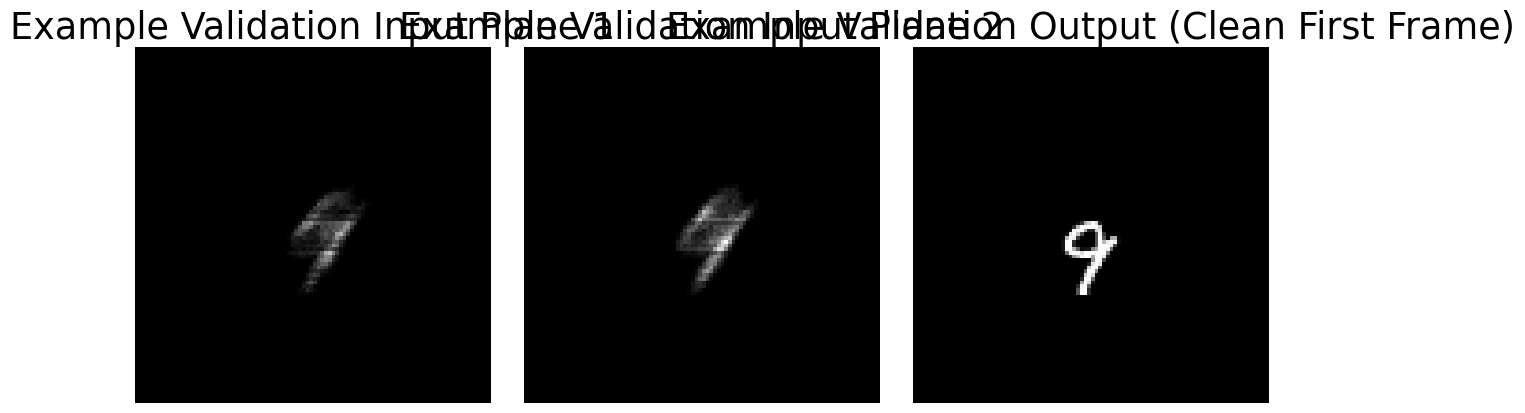

In [25]:
# prompt: using the code from above generate 500 test and validation input output sets. normalize the inputs to lie between 0 and 1


# Initialize lists to store validation data
X_val = []
y_val = []
noise_factor=5
print(f"\nGenerating {num_samples} validation examples...")

# Generate validation input-output pairs
# Reuse the same selected_digits for consistency, but generate new motion/noise
for i, digit_image in enumerate(selected_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40,noise_scale_factor=noise_factor)

    # Generate the encoded input (coded frames)
    # Use the same initial code for consistency
    if 'tiled_code' in locals():
        initial_code = tiled_code
    else:
        initial_code = np.random.choice([1, -1], size=(96, 96))

    dp1, dp2 = generate_coded_data_planes(video_stack, initial_code)
    # Concatenate the two data planes to form the input features
    # Shape will be (height, width, 2)
    encoded_input = np.stack([dp1, dp2], axis=-1)

    # Normalize the encoded input to be between 0 and 1
    min_val = np.min(encoded_input)
    max_val = np.max(encoded_input)
    if max_val - min_val > 1e-6:
      normalized_encoded_input = (encoded_input - min_val) / (max_val - min_val)
    else:
      normalized_encoded_input = np.zeros_like(encoded_input)


    # Generate the output (uncorrupted first frame)
    clean_first_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_first_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]


    X_val.append(normalized_encoded_input)
    y_val.append(clean_first_frame)

    if (i + 1) % 100 == 0 or i == num_samples - 1:
        print(f"  Generated {i + 1}/{num_samples} samples")

# Convert lists to numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)

# Add a channel dimension to y_val
y_val = np.expand_dims(y_val, axis=-1)


print("\nValidation data shapes:")
print("Input (X_val):", X_val.shape) # Should be (num_samples, height, width, 2)
print("Output (y_val):", y_val.shape) # Should be (num_samples, height, width, 1)

# Display an example validation pair
example_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_val[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Input Plane 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X_val[example_idx, :, :, 1], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Input Plane 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_val[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Validation Output (Clean First Frame)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Neural estimator

In [26]:
# prompt:  create a 4 layer unet with skip connections to associate the input planes to the output planes with gelu activation functions for the hidden layers and linear activation for the final layer with MSE loss. Use 4 filters in the first layer, 8 in the second layer, 16 in the third, 32 in the fourth and then 32 16, 8 4 in the decoder


def unet_model(input_shape=(96, 96, 2)):
    inputs = Input(input_shape)

    # Encoder (Downsampling path)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(inputs)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(pool1)
    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(pool2)
    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool3)
    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck layer
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool4)
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv5)

    # Decoder (Upsampling path with skip connections)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(up6)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(up7)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(up8)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(up9)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv9)

    # Output layer (Linear activation for reconstruction)
    outputs = Conv2D(1, (1, 1), activation='linear')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='mse')

    return model

# Create the model
model = unet_model()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 96, 96, 4) │         76 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 96, 96, 4) │        148 │ conv2d_38[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 48, 48, 4) │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 48, 48, 8) │        296 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 48, 48, 8) │        584 │ conv2d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 24, 24, 8) │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 24, 24,    │      1,168 │ max_pooling2d_9[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 24, 24,    │      2,320 │ conv2d_42[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 12, 12,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 12, 12,    │      4,640 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 12, 12,    │      9,248 │ conv2d_44[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 6, 6, 32)  │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 6, 6, 32)  │      9,248 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 6, 6, 32)  │      9,248 │ conv2d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 12, 12,    │          0 │ conv2d_47[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 12, 12,    │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 64)               │            │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 12, 12,    │     18,464 │ concatenate_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 12, 12,    │      9,248 │ conv2d_48[0][0] 

 Total params: 76,845 (300.18 KB)

 Trainable params: 76,845 (300.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━

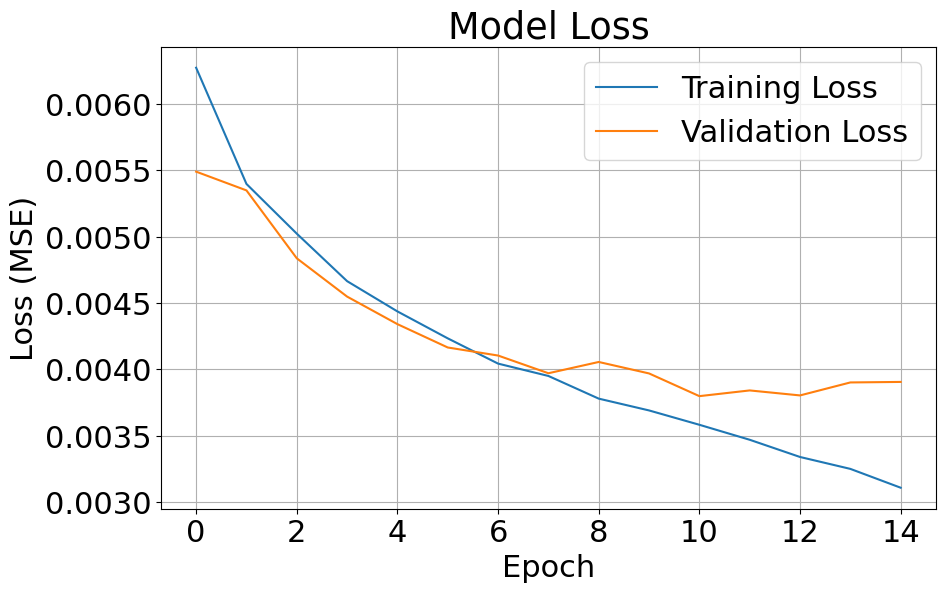

In [27]:
# prompt: train the network with the training and validation data sets from above

import matplotlib.pyplot as plt
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,  # Or a number of epochs suitable for your data size
    batch_size=32  # Or a batch size that fits your memory
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Processing 40 frames...
  Processed frame 5/40
  Processed frame 10/40
  Processed frame 15/40
  Processed frame 20/40
  Processed frame 25/40
  Processed frame 30/40
  Processed frame 35/40
  Processed frame 40/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

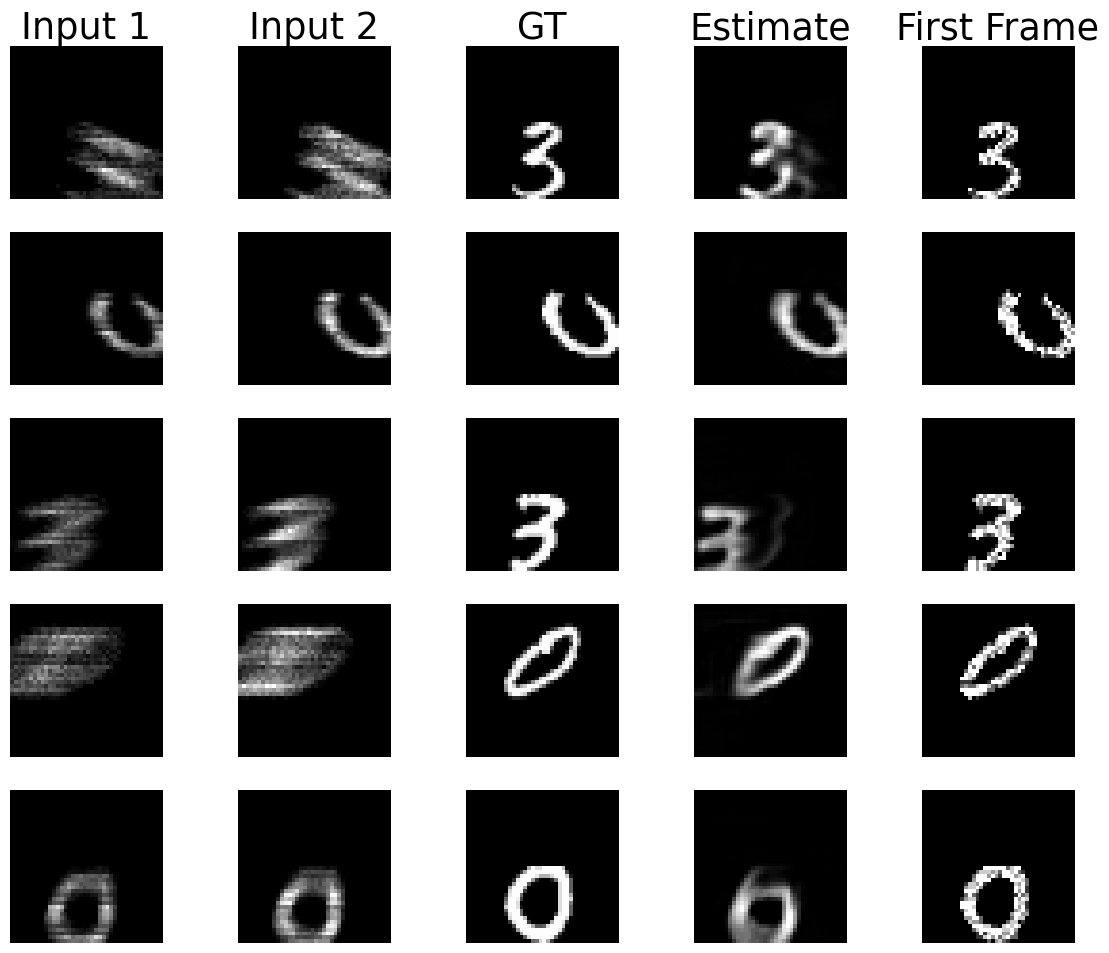

In [40]:
# prompt:  choose random digits from the test data set, for each digit generate a noisy video, then generate a normalized input and output pair, predict the output from the input. using 4 rows, on each row show the the input and output pairs, the output predicted by the network and the first frame of the noisy video. crop each image to the 40 by 40 pixel region surrounding its maximum point

def crop_around_max(image, crop_size=(64, 64)):
    """
    Finds the maximum pixel location in an image and crops a region
    of size crop_size around it. Handles boundary conditions.

    Args:
        image (np.ndarray): The input 2D image array.
        crop_size (tuple): The (height, width) of the desired output crop.

    Returns:
        np.ndarray: The cropped image array.
    """
    if image is None or image.size == 0:
        return np.zeros(crop_size) # Return empty crop if image is empty

    h, w = image.shape
    crop_h, crop_w = crop_size

    # Find the location of the maximum value
    max_coords = np.unravel_index(np.argmax(image), image.shape)
    max_y, max_x = max_coords

    # Calculate crop boundaries
    # Center the crop around (max_x, max_y)
    start_x = max_x - crop_w // 2
    start_y = max_y - crop_h // 2
    end_x = start_x + crop_w
    end_y = start_y + crop_h

    # Handle boundary conditions using padding
    pad_left = max(0, -start_x)
    pad_top = max(0, -start_y)
    pad_right = max(0, end_x - w)
    pad_bottom = max(0, end_y - h)

    # Pad the image if necessary
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

    # Adjust crop coordinates relative to the padded image
    padded_start_x = start_x + pad_left
    padded_start_y = start_y + pad_top
    padded_end_x = padded_start_x + crop_w
    padded_end_y = padded_start_y + crop_h

    # Crop from the padded image
    cropped_image = padded_image[padded_start_y:padded_end_y, padded_start_x:padded_end_x]

    return cropped_image

# --- Main display loop for 4 examples ---

num_examples_to_show = 5
crop_dimensions = (40, 40)
random_test_idx = np.random.randint(0, len(mnist_test_images), num_examples_to_show)
# Load the MNIST dataset if not already loaded
if 'mnist_test_images' not in globals():
    (mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

plt.figure(figsize=(12, 10))

for i in range(num_examples_to_show):
    # Choose a random digit from the test data set
    #random_test_idx = np.random.randint(0, len(mnist_test_images))
    test_digit_image_clean = mnist_test_images[random_test_idx[i]].astype(np.float32) / 255.0

    # Generate a noisy video with this digit
    noisy_video_stack, test_start_pos = generate_noisy_digit_motion(
        digit_image=test_digit_image_clean,
        frame_size=(96, 96),
        num_frames=40,
        noise_scale_factor=5 # You can adjust noise here
    )

    # Generate the normalized input pair from the noisy video
    # Use the same initial code as used for training data
    if 'tiled_code' in locals():
        initial_code_test = tiled_code
    else:
        initial_code_test = np.random.choice([1, -1], size=(96, 96))

    test_dp1, test_dp2 = generate_coded_data_planes(noisy_video_stack, initial_code_test)
    encoded_input_test = np.stack([test_dp1, test_dp2], axis=-1)

    # Normalize the input using the min/max from the training data (or test data)
    # Using test data's min/max for this example
    min_val_test = np.min(encoded_input_test)
    max_val_test = np.max(encoded_input_test)
    if max_val_test - min_val_test > 1e-6:
      normalized_encoded_input_test_full = (encoded_input_test - min_val_test) / (max_val_test - min_val_test)
    else:
      normalized_encoded_input_test_full = np.zeros_like(encoded_input_test)

    # Reshape for model prediction (add batch dimension)
    normalized_encoded_input_test_batch = np.expand_dims(normalized_encoded_input_test_full, axis=0)


    # Generate the corresponding clean output (uncorrupted first frame)
    clean_output_test_full = np.zeros((96, 96), dtype=np.float32)
    test_start_x = test_start_pos[0, 0]
    test_start_y = test_start_pos[0, 1]
    digit_h, digit_w = test_digit_image_clean.shape

    clip_x_start = max(0, test_start_x)
    clip_y_start = max(0, test_start_y)
    clip_x_end = min(96, test_start_x + digit_w)
    clip_y_end = min(96, test_start_y + digit_h)

    digit_clip_x_start = max(0, -test_start_x)
    digit_clip_y_start = max(0, -test_start_y)
    digit_clip_x_end = digit_w - max(0, (test_start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (test_start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_output_test_full[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            test_digit_image_clean[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

    # Predict the output from the input
    predicted_output_batch = model.predict(normalized_encoded_input_test_batch)
    predicted_output_full = predicted_output_batch[0, :, :, 0] # Remove batch and channel dims


    # --- Cropping Images Around Max ---

    # Find the max location in the clean output (ground truth)
    # Use the max location from the ground truth to crop all images consistently
    if clean_output_test_full.max() > 1e-6: # Only find max if there's a digit
        max_coords_gt = np.unravel_index(np.argmax(clean_output_test_full), clean_output_test_full.shape)
        max_y_gt, max_x_gt = max_coords_gt
    else:
        # If the ground truth is all zero, just center the crop
        max_y_gt, max_x_gt = clean_output_test_full.shape[0] // 2, clean_output_test_full.shape[1] // 2


    # Calculate crop boundaries based on the max location from ground truth
    start_x_crop = max_x_gt - crop_dimensions[1] // 2
    start_y_crop = max_y_gt - crop_dimensions[0] // 2
    end_x_crop = start_x_crop + crop_dimensions[1]
    end_y_crop = start_y_crop + crop_dimensions[0]

    # Crop the images, handling boundaries
    # We can use a helper function or manually handle padding/clipping for each image.
    # Let's use the crop_around_max function and pass the identified max location.

    # NOTE: The crop_around_max function finds the max *within* the image it's given.
    # To crop all images based on the *same* maximum point (from the ground truth),
    # we need a function that crops based on a fixed center, handling boundaries.
    # Let's refine the cropping logic or adjust crop_around_max.

    # Let's redefine crop_around_center for consistency
    def crop_around_center(image, center_coords, crop_size):
        h, w = image.shape
        center_y, center_x = center_coords
        crop_h, crop_w = crop_size

        start_x = center_x - crop_w // 2
        start_y = center_y - crop_h // 2
        end_x = start_x + crop_w
        end_y = start_y + crop_h

        pad_left = max(0, -start_x)
        pad_top = max(0, -start_y)
        pad_right = max(0, end_x - w)
        pad_bottom = max(0, end_y - h)

        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

        padded_start_x = start_x + pad_left
        padded_start_y = start_y + pad_top
        padded_end_x = padded_start_x + crop_w
        padded_end_y = padded_start_y + crop_h

        cropped_image = padded_image[padded_start_y:padded_end_y, padded_start_x:padded_end_x]
        return cropped_image


    # Apply the crop centered around the ground truth max
    cropped_input_plane1 = crop_around_center(normalized_encoded_input_test_full[:, :, 0], (max_y_gt, max_x_gt), crop_dimensions)
    cropped_input_plane2 = crop_around_center(normalized_encoded_input_test_full[:, :, 1], (max_y_gt, max_x_gt), crop_dimensions)
    cropped_clean_output = crop_around_center(clean_output_test_full, (max_y_gt, max_x_gt), crop_dimensions)
    cropped_predicted_output = crop_around_center(predicted_output_full, (max_y_gt, max_x_gt), crop_dimensions)
    cropped_noisy_first_frame = crop_around_center(noisy_video_stack[0], (max_y_gt, max_x_gt), crop_dimensions)


    # --- Displaying the cropped images ---

    # Row i: Input 1 (cropped), Input 2 (cropped), Clean Output (cropped), Predicted Output (cropped), Noisy First Frame (cropped)

    plt.subplot(num_examples_to_show, 5, i * 5 + 1)
    plt.imshow(cropped_input_plane1, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('Input 1')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 5, i * 5 + 2)
    plt.imshow(cropped_input_plane2, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('Input 2')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 5, i * 5 + 3)
    plt.imshow(cropped_clean_output, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('GT')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 5, i * 5 + 4)
    plt.imshow(cropped_predicted_output, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('Estimate')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 5, i * 5 + 5)
    plt.imshow(cropped_noisy_first_frame, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('First Frame')
    plt.axis('off')


plt.tight_layout()
plt.savefig('cropped_examples.png')
plt.show()



In [30]:

model.save('twoPlaneModel.keras')

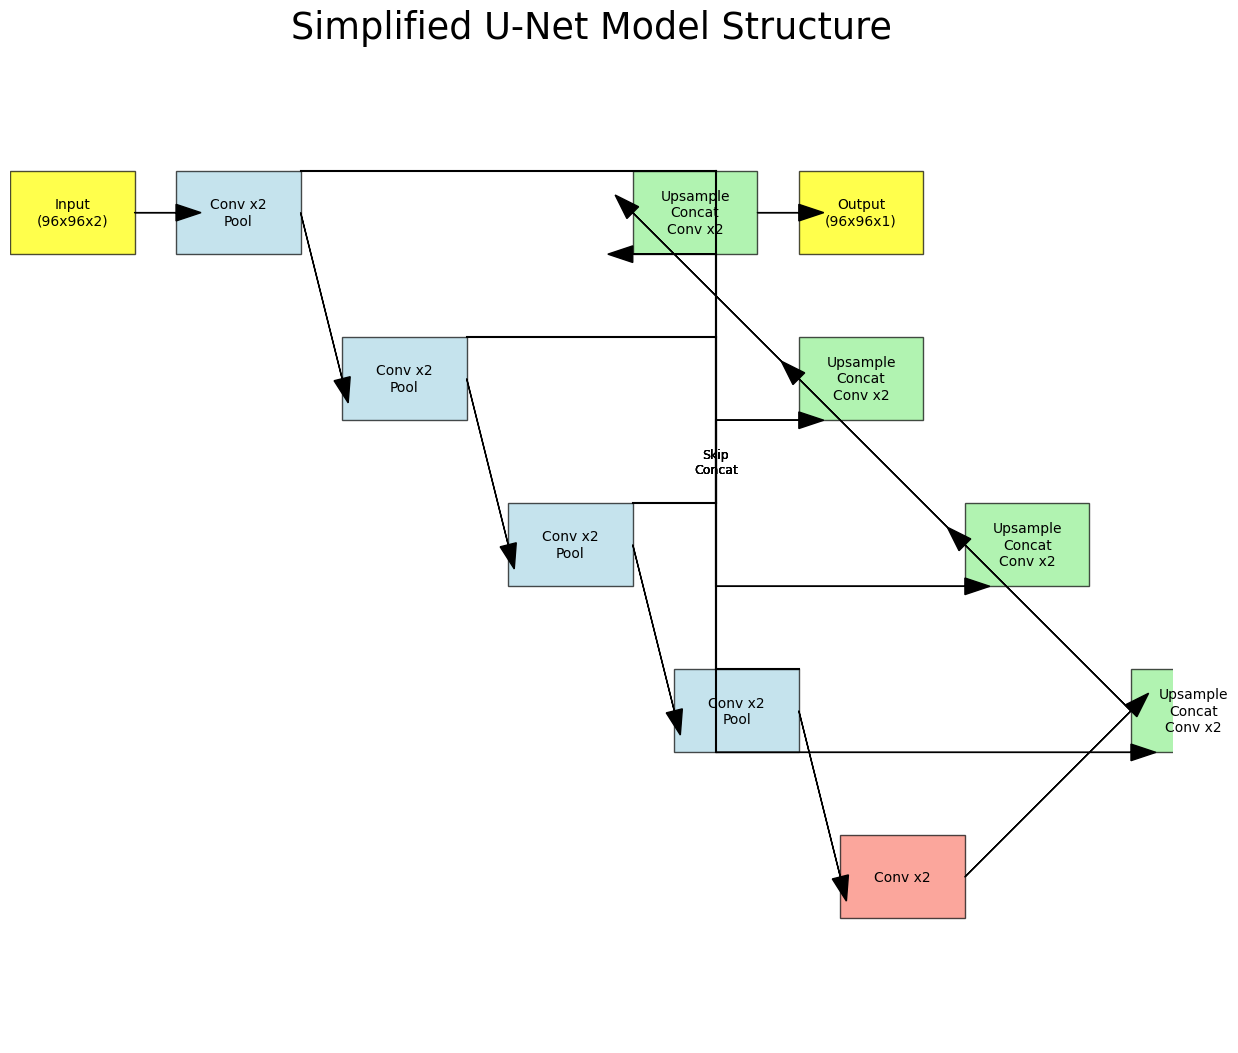

In [ ]:
# prompt: make a simple block diagram showing the structure of the neural model

# To make a simple block diagram, we can use matplotlib patches and text
# to represent the structure.

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_unet_diagram(figsize=(15, 15)):
    """
    Draws a simplified block diagram of the U-Net model architecture.
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("Simplified U-Net Model Structure")
    ax.axis('off') # Hide axes

    # Define coordinates for blocks (approximate positions)
    x_enc = [0, 2, 4, 6, 8] # Encoder x positions
    y_levels = [8, 6, 4, 2, 0] # y positions for different levels (higher is top)

    block_width = 1.5
    block_height = 1.0

    # Encoder Blocks
    enc_blocks = []
    for i in range(4):
        rect = patches.Rectangle((x_enc[i], y_levels[i] - block_height/2), block_width, block_height, linewidth=1, edgecolor='black', facecolor='lightblue', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x_enc[i] + block_width/2, y_levels[i], f'Conv x2\nPool', ha='center', va='center', fontsize=10)
        enc_blocks.append((x_enc[i] + block_width, y_levels[i])) # Store right edge for connections

    # Bottleneck
    bottleneck_x = x_enc[4]
    bottleneck_y = y_levels[4]
    rect = patches.Rectangle((bottleneck_x, bottleneck_y - block_height/2), block_width, block_height, linewidth=1, edgecolor='black', facecolor='salmon', alpha=0.7)
    ax.add_patch(rect)
    ax.text(bottleneck_x + block_width/2, bottleneck_y, 'Conv x2', ha='center', va='center', fontsize=10)


    # Decoder Blocks
    dec_blocks = []
    x_dec = [x_enc[4] + block_width + 2, x_enc[3] + block_width + 2, x_enc[2] + block_width + 2, x_enc[1] + block_width + 2]
    y_levels_dec = [y_levels[3], y_levels[2], y_levels[1], y_levels[0]]


    for i in range(4):
        rect = patches.Rectangle((x_dec[i], y_levels_dec[i] - block_height/2), block_width, block_height, linewidth=1, edgecolor='black', facecolor='lightgreen', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x_dec[i] + block_width/2, y_levels_dec[i], f'Upsample\nConcat\nConv x2', ha='center', va='center', fontsize=10)
        dec_blocks.append((x_dec[i], y_levels_dec[i])) # Store left edge for connections

    # Input and Output
    input_x = x_enc[0] - block_width - 0.5
    input_y = y_levels[0]
    rect = patches.Rectangle((input_x, input_y - block_height/2), block_width, block_height, linewidth=1, edgecolor='black', facecolor='yellow', alpha=0.7)
    ax.add_patch(rect)
    ax.text(input_x + block_width/2, input_y, 'Input\n(96x96x2)', ha='center', va='center', fontsize=10)

    output_x = x_dec[-1] + block_width + 0.5
    output_y = y_levels_dec[-1]
    rect = patches.Rectangle((output_x, output_y - block_height/2), block_width, block_height, linewidth=1, edgecolor='black', facecolor='yellow', alpha=0.7)
    ax.add_patch(rect)
    ax.text(output_x + block_width/2, output_y, 'Output\n(96x96x1)', ha='center', va='center', fontsize=10)

    # Connections (Arrows)
    # Input to first encoder
    ax.arrow(input_x + block_width, input_y, x_enc[0] - (input_x + block_width), 0,
             head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Encoder to Encoder (Downsampling path)
    for i in range(3):
        ax.arrow(enc_blocks[i][0], enc_blocks[i][1], x_enc[i+1] - enc_blocks[i][0], y_levels[i+1] - y_levels[i],
                 head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Last encoder to Bottleneck
    ax.arrow(enc_blocks[3][0], enc_blocks[3][1], bottleneck_x - enc_blocks[3][0], y_levels[4] - y_levels[3],
             head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Bottleneck to first Decoder
    ax.arrow(bottleneck_x + block_width, bottleneck_y, dec_blocks[0][0] - (bottleneck_x + block_width), y_levels_dec[0] - bottleneck_y,
             head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Decoder to Decoder (Upsampling path)
    for i in range(3):
        ax.arrow(dec_blocks[i][0], dec_blocks[i][1], x_dec[i+1] - dec_blocks[i][0], y_levels_dec[i+1] - y_levels_dec[i],
                 head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Last decoder to Output
    ax.arrow(dec_blocks[3][0] + block_width, dec_blocks[3][1], output_x - (dec_blocks[3][0] + block_width), 0,
             head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Skip Connections
    skip_offset_y = 0.5 # Vertical offset for drawing the skip line
    for i in range(4):
        # Draw horizontal line from encoder block
        ax.plot([enc_blocks[i][0], enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2],
                [enc_blocks[i][1] + skip_offset_y, enc_blocks[i][1] + skip_offset_y], 'k-')
        # Draw vertical line down/up
        ax.plot([enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2, enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2],
                [enc_blocks[i][1] + skip_offset_y, y_levels_dec[i] - skip_offset_y], 'k-')
        # Draw horizontal line to decoder block and arrow
        ax.arrow(enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2, y_levels_dec[i] - skip_offset_y,
                 dec_blocks[i][0] - (enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2), 0,
                 head_width=0.2, head_length=0.3, fc='black', ec='black')
        ax.text(enc_blocks[i][0] + (dec_blocks[i][0] - enc_blocks[i][0])/2, (enc_blocks[i][1] + skip_offset_y + y_levels_dec[i] - skip_offset_y)/2,
                'Skip\nConcat', ha='center', va='center', fontsize=9)


    # Set plot limits
    ax.set_xlim(-2, 12)
    ax.set_ylim(-2, 10)

    plt.show()

# Draw the diagram
draw_unet_diagram()


## learned filter

In [31]:
def unet_model40(input_shape=(96, 96, 40)):
    inputs = Input(input_shape)
    conv0 =Conv2D(1, (2, 2), activation=gelu, padding='same')(inputs)

    # Encoder (Downsampling path)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv0)
    conv1 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(pool1)
    conv2 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(pool2)
    conv3 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool3)
    conv4 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck layer
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(pool4)
    conv5 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv5)

    # Decoder (Upsampling path with skip connections)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(up6)
    conv6 = Conv2D(32, (3, 3), activation=gelu, padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(up7)
    conv7 = Conv2D(16, (3, 3), activation=gelu, padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(up8)
    conv8 = Conv2D(8, (3, 3), activation=gelu, padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(up9)
    conv9 = Conv2D(4, (3, 3), activation=gelu, padding='same')(conv9)

    # Output layer (Linear activation for reconstruction)
    outputs = Conv2D(1, (1, 1), activation='linear')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='mse')

    return model

# Create the model
model40 = unet_model40()
model40.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96,    │          0 │ -                 │
│ (InputLayer)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 96, 96, 1) │        161 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 96, 96, 4) │         40 │ conv2d_57[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 96, 96, 4) │        148 │ conv2d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 48, 48, 4) │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 48, 48, 8) │        296 │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 48, 48, 8) │        584 │ conv2d_60[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 24, 24, 8) │          0 │ conv2d_61[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 24, 24,    │      1,168 │ max_pooling2d_13… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 24, 24,    │      2,320 │ conv2d_62[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 12, 12,    │          0 │ conv2d_63[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 12, 12,    │      4,640 │ max_pooling2d_14… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 12, 12,    │      9,248 │ conv2d_64[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 6, 6, 32)  │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 6, 6, 32)  │      9,248 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 6, 6, 32)  │      9,248 │ conv2d_66[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 12, 12,    │          0 │ conv2d_67[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 12, 12,    │          0 │ up_sampling2d_12… │
│ (Concatenate)       │ 64)               │            │ conv2d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 12, 12,    │     18,464 │ concatenate_12[0… │
│                     │ 32)               │            │                 

 Total params: 76,970 (300.66 KB)

 Trainable params: 76,970 (300.66 KB)

 Non-trainable params: 0 (0.00 B)

Generating 5000 training examples...
  Generated 100/5000 training samples
  Generated 200/5000 training samples
  Generated 300/5000 training samples
  Generated 400/5000 training samples
  Generated 500/5000 training samples
  Generated 600/5000 training samples
  Generated 700/5000 training samples
  Generated 800/5000 training samples
  Generated 900/5000 training samples
  Generated 1000/5000 training samples
  Generated 1100/5000 training samples
  Generated 1200/5000 training samples
  Generated 1300/5000 training samples
  Generated 1400/5000 training samples
  Generated 1500/5000 training samples
  Generated 1600/5000 training samples
  Generated 1700/5000 training samples
  Generated 1800/5000 training samples
  Generated 1900/5000 training samples
  Generated 2000/5000 training samples
  Generated 2100/5000 training samples
  Generated 2200/5000 training samples
  Generated 2300/5000 training samples
  Generated 2400/5000 training samples
  Generated 2500/5000 training sampl

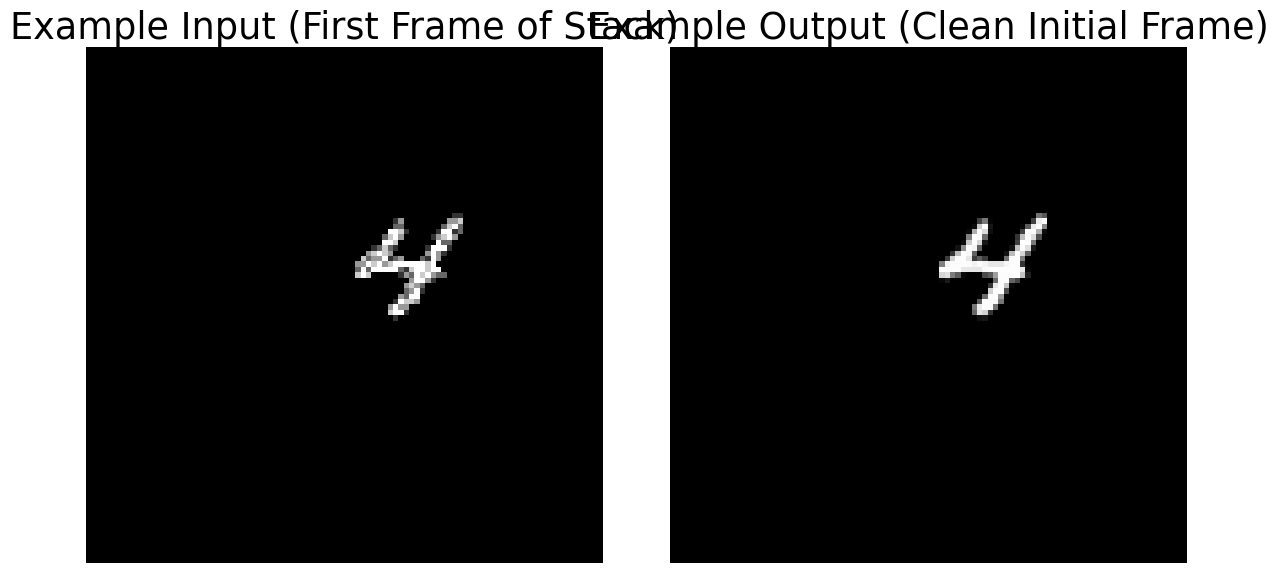

In [32]:
# prompt: create 5000 training input output pairs where the input is a 96 by 96 by 40 tensor generated from  generate_noisy_digit_motion and the output is the noise free initial frame. similarly generate 500 validation input output pairs

num_train_samples = 5000
num_val_samples = 500
noise_factor = 5 # Can adjust noise level here

# Load the MNIST dataset if not already loaded
if 'mnist_train_images' not in globals():
    (mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

# Select random indices for training and validation from the MNIST dataset
random_train_indices = np.random.choice(len(mnist_train_images), num_train_samples, replace=False)
selected_train_digits = mnist_train_images[random_train_indices]

random_val_indices = np.random.choice(len(mnist_test_images), num_val_samples, replace=False)
selected_val_digits = mnist_test_images[random_val_indices]


# Initialize lists to store training data
X_train_40 = []
y_train_40 = []

print(f"Generating {num_train_samples} training examples...")

# Generate training input-output pairs
for i, digit_image in enumerate(selected_train_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack (input is the full stack)
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40, noise_scale_factor=noise_factor)

    # The input is the entire video stack (96x96x40)
    # Normalize the input video stack to be between 0 and 1 if necessary
    # Assuming the generate_noisy_digit_motion already produces values between 0 and 1
    input_video_stack = video_stack # Shape (40, 96, 96)

    # The output is the noise-free initial frame (96x96)
    clean_initial_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    # Place the clean digit image into the clean frame at the start position
    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_initial_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

    # The video stack has shape (frames, height, width). The model expects (height, width, frames).
    # We need to transpose the input video stack.
    X_train_40.append(np.transpose(input_video_stack, (1, 2, 0))) # Transpose to (96, 96, 40)
    y_train_40.append(clean_initial_frame) # Shape (96, 96)

    if (i + 1) % 100 == 0 or i == num_train_samples - 1:
        print(f"  Generated {i + 1}/{num_train_samples} training samples")

# Convert lists to numpy arrays
X_train_40 = np.array(X_train_40)
y_train_40 = np.array(y_train_40)

# Add a channel dimension to y_train_40 if needed for model compatibility
y_train_40 = np.expand_dims(y_train_40, axis=-1) # Should be (num_train_samples, 96, 96, 1)


print("\nTraining data shapes:")
print("Input (X_train_40):", X_train_40.shape) # Should be (num_train_samples, 96, 96, 40)
print("Output (y_train_40):", y_train_40.shape) # Should be (num_train_samples, 96, 96, 1)


# Initialize lists to store validation data
X_val_40 = []
y_val_40 = []

print(f"\nGenerating {num_val_samples} validation examples...")

# Generate validation input-output pairs
for i, digit_image in enumerate(selected_val_digits):
    # Normalize MNIST digit image to be between 0 and 1
    digit_image = digit_image.astype(np.float32) / 255.0

    # Generate noisy digit motion video stack
    video_stack, start_pos = generate_noisy_digit_motion(digit_image=digit_image, frame_size=(96, 96), num_frames=40, noise_scale_factor=noise_factor)

    # Input is the entire video stack (96x96x40)
    input_video_stack = video_stack # Shape (40, 96, 96)

    # Output is the noise-free initial frame (96x96)
    clean_initial_frame = np.zeros((96, 96), dtype=np.float32)
    start_x = start_pos[0, 0]
    start_y = start_pos[0, 1]
    digit_h, digit_w = digit_image.shape

    # Place the clean digit image into the clean frame at the start position
    clip_x_start = max(0, start_x)
    clip_y_start = max(0, start_y)
    clip_x_end = min(96, start_x + digit_w)
    clip_y_end = min(96, start_y + digit_h)

    digit_clip_x_start = max(0, -start_x)
    digit_clip_y_start = max(0, -start_y)
    digit_clip_x_end = digit_w - max(0, (start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_initial_frame[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            digit_image[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]


    X_val_40.append(np.transpose(input_video_stack, (1, 2, 0))) # Transpose to (96, 96, 40)
    y_val_40.append(clean_initial_frame) # Shape (96, 96)

    if (i + 1) % 100 == 0 or i == num_val_samples - 1:
        print(f"  Generated {i + 1}/{num_val_samples} validation samples")


# Convert lists to numpy arrays
X_val_40 = np.array(X_val_40)
y_val_40 = np.array(y_val_40)

# Add a channel dimension to y_val_40
y_val_40 = np.expand_dims(y_val_40, axis=-1) # Should be (num_val_samples, 96, 96, 1)


print("\nValidation data shapes:")
print("Input (X_val_40):", X_val_40.shape) # Should be (num_val_samples, 96, 96, 40)
print("Output (y_val_40):", y_val_40.shape) # Should be (num_val_samples, 96, 96, 1)

# Display an example training pair
example_idx = 0
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
# Displaying the first frame of the input video stack as an example of input appearance
plt.imshow(X_train_40[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Input (First Frame of Stack)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y_train_40[example_idx, :, :, 0], cmap='gray', vmin=0, vmax=1)
plt.title('Example Output (Clean Initial Frame)')
plt.axis('off')

plt.tight_layout()
plt.show()

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0013 - val_loss: 7.9039e-04
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 7.0991e-04 - val_loss: 5.3482e-04
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 5.0053e-04 - val_loss: 4.0492e-04
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.9119e-04 - val_loss: 3.3397e-04
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.3104e-04 - val_loss: 2.9451e-04
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.9475e-04 - val_loss: 2.7644e-04
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.7050e-04 - val_loss: 2.5463e-04
Epoch 9/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.5754e-04 - val_loss: 2.4556e-04
Epoch 10/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.4598e-04 - val_loss: 2.3881e-04
Epoch 11/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss

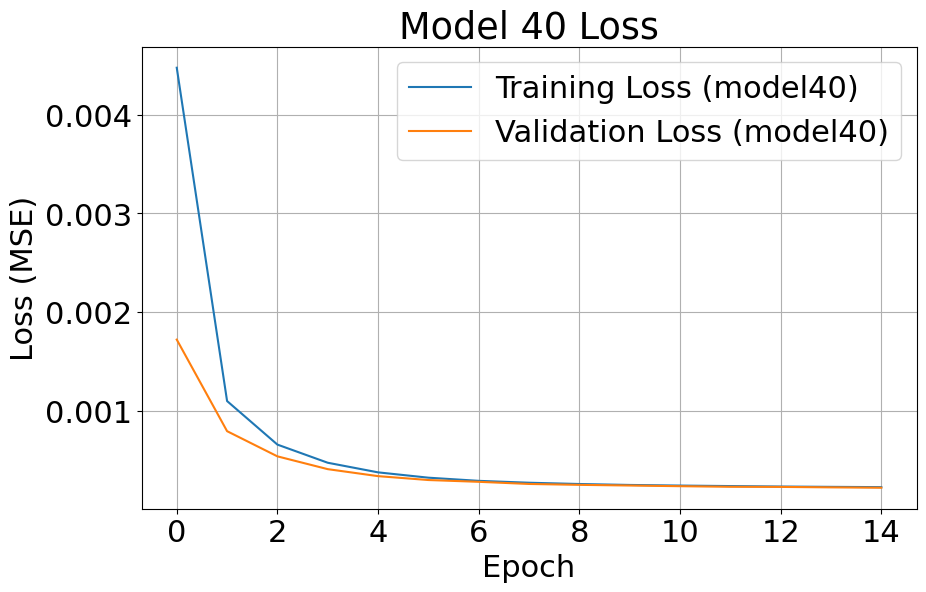

In [33]:
# prompt: train model40 using the training and validation pairs generated above

import matplotlib.pyplot as plt
history40 = model40.fit(
    X_train_40, y_train_40,
    validation_data=(X_val_40, y_val_40),
    epochs=15,  # Or a number of epochs suitable for your data size
    batch_size=32  # Or a batch size that fits your memory
)

# Plot training history for model40
plt.figure(figsize=(10, 6))
plt.plot(history40.history['loss'], label='Training Loss (model40)')
plt.plot(history40.history['val_loss'], label='Validation Loss (model40)')
plt.title('Model 40 Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


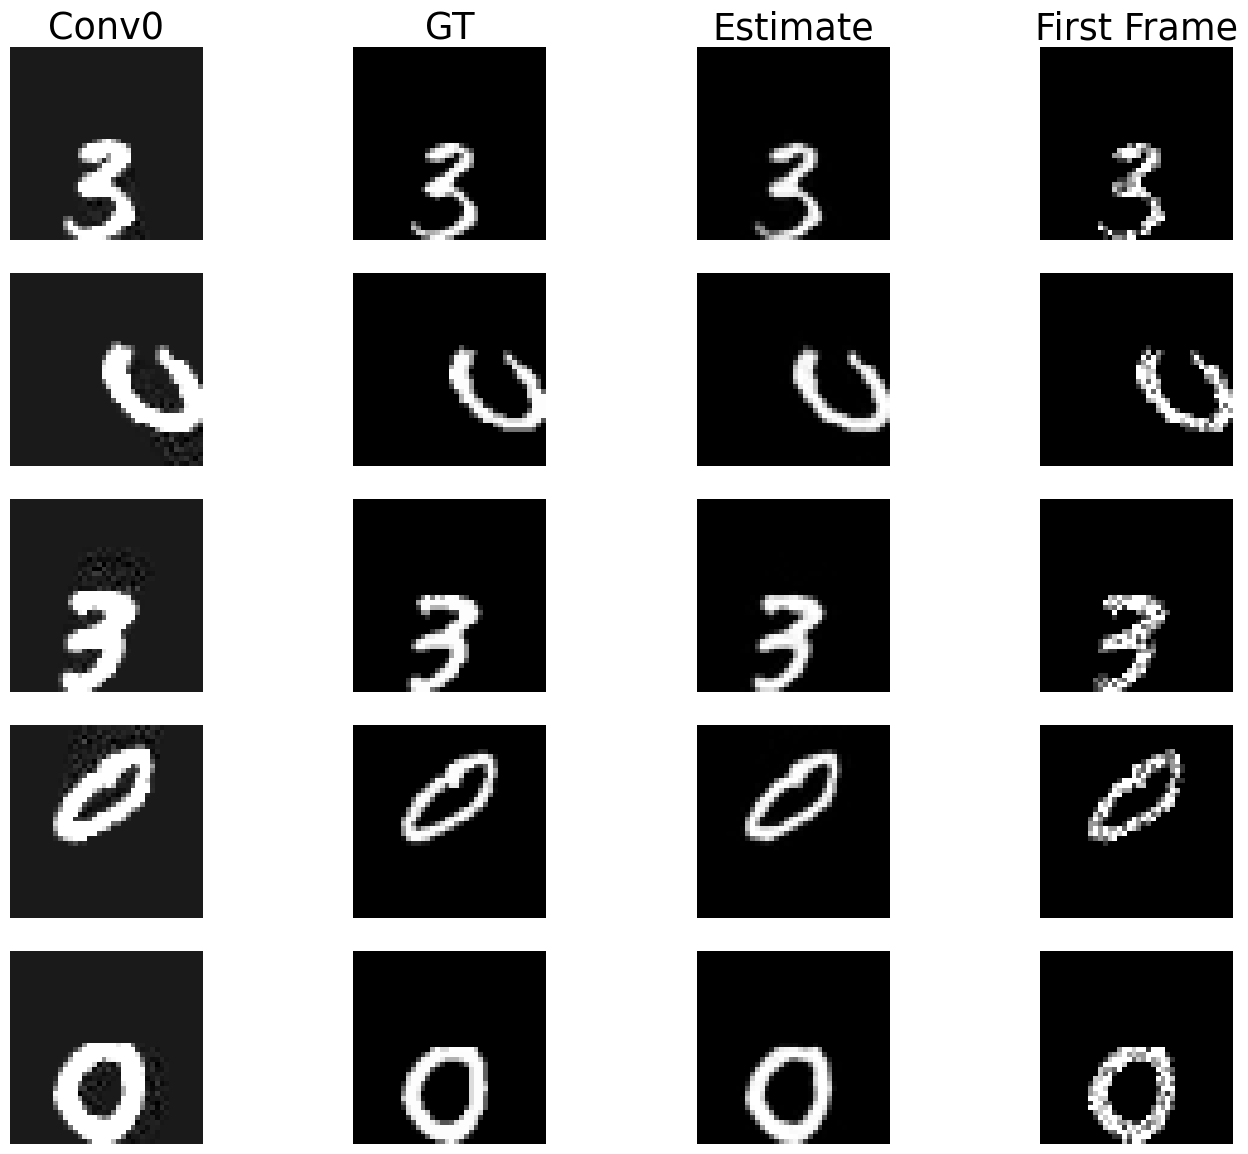

In [42]:
# prompt: from 5 randomly selected MNIST digits generate a noisy video of 40 frames, use model 40 to predict the first frame. display in a 5 by 4 grid the output of the conv0 layer of the network,  true noiseless first frame, the estimated first frame and the noisy first frame

import matplotlib.pyplot as plt
import numpy as np
num_examples_to_show = 5
crop_dimensions = (40, 40) # Adjust crop size as needed
#random_test_idx = np.random.choice(len(mnist_test_images), num_examples_to_show, replace=False)


# Load the MNIST dataset if not already loaded
if 'mnist_test_images' not in globals():
    (mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

plt.figure(figsize=(15, 12)) # Adjust figure size for the 5x4 grid

# Get the output of the conv0 layer
# We need to create a model that outputs the conv0 layer's activation
conv0_output_model = Model(inputs=model40.input, outputs=model40.get_layer('conv2d_57').output)


for i in range(num_examples_to_show):
    # Choose a random digit from the test data set
    test_digit_image_clean = mnist_test_images[random_test_idx[i]].astype(np.float32) / 255.0

    # Generate a noisy video with this digit
    noisy_video_stack, test_start_pos = generate_noisy_digit_motion(
        digit_image=test_digit_image_clean,
        frame_size=(96, 96),
        num_frames=40,
        noise_scale_factor=5 # Use the same noise factor as training
    )

    # Input is the entire noisy video stack for model40
    input_video_stack_test = np.transpose(noisy_video_stack, (1, 2, 0)) # Shape (96, 96, 40)
    input_video_stack_test_batch = np.expand_dims(input_video_stack_test, axis=0) # Add batch dim

    # Predict the output from the input using model40
    predicted_output_batch = model40.predict(input_video_stack_test_batch)
    predicted_output_full = predicted_output_batch[0, :, :, 0] # Remove batch and channel dims

    # Get the output of the conv0 layer
    conv0_output_batch = conv0_output_model.predict(input_video_stack_test_batch)
    # The conv0 output has shape (1, 96, 96, 1)
    conv0_output_full = conv0_output_batch[0, :, :, 0] # Remove batch and channel dims


    # Generate the corresponding clean output (uncorrupted first frame)
    clean_output_test_full = np.zeros((96, 96), dtype=np.float32)
    test_start_x = test_start_pos[0, 0]
    test_start_y = test_start_pos[0, 1]
    digit_h, digit_w = test_digit_image_clean.shape

    clip_x_start = max(0, test_start_x)
    clip_y_start = max(0, test_start_y)
    clip_x_end = min(96, test_start_x + digit_w)
    clip_y_end = min(96, test_start_y + digit_h)

    digit_clip_x_start = max(0, -test_start_x)
    digit_clip_y_start = max(0, -test_start_y)
    digit_clip_x_end = digit_w - max(0, (test_start_x + digit_w) - 96)
    digit_clip_y_end = digit_h - max(0, (test_start_y + digit_h) - 96)

    if (clip_x_end > clip_x_start and clip_y_end > clip_y_start and
        digit_clip_x_end > digit_clip_x_start and digit_clip_y_end > digit_clip_y_start):
        clean_output_test_full[clip_y_start:clip_y_end, clip_x_start:clip_x_end] = \
            test_digit_image_clean[digit_clip_y_start:digit_clip_y_end, digit_clip_x_start:digit_clip_x_end]

    # Get the noisy first frame
    noisy_first_frame_full = noisy_video_stack[0]


    # --- Cropping Images ---

    # Find the max location in the clean output (ground truth) to center the crop
    if clean_output_test_full.max() > 1e-6:
        max_coords_gt = np.unravel_index(np.argmax(clean_output_test_full), clean_output_test_full.shape)
        max_y_gt, max_x_gt = max_coords_gt
    else:
        # If the ground truth is all zero, just center the crop
        max_y_gt, max_x_gt = clean_output_test_full.shape[0] // 2, clean_output_test_full.shape[1] // 2


    # Apply the crop centered around the ground truth max
    cropped_conv0_output = crop_around_center(conv0_output_full, (max_y_gt, max_x_gt), crop_dimensions)
    cropped_clean_output = crop_around_center(clean_output_test_full, (max_y_gt, max_x_gt), crop_dimensions)
    cropped_predicted_output = crop_around_center(predicted_output_full, (max_y_gt, max_x_gt), crop_dimensions)
    cropped_noisy_first_frame = crop_around_center(noisy_first_frame_full, (max_y_gt, max_x_gt), crop_dimensions)


    # --- Displaying the cropped images ---

    # Row i: conv0 output, true noiseless first frame, estimated first frame, noisy first frame

    plt.subplot(num_examples_to_show, 4, i * 4 + 1)
    plt.imshow(cropped_conv0_output, cmap='gray', vmin=0, vmax=1) # Adjust vmin/vmax if conv0 output range is different
    if i == 0: plt.title('Conv0')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 4, i * 4 + 2)
    plt.imshow(cropped_clean_output, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('GT')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 4, i * 4 + 3)
    plt.imshow(cropped_predicted_output, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('Estimate')
    plt.axis('off')

    plt.subplot(num_examples_to_show, 4, i * 4 + 4)
    plt.imshow(cropped_noisy_first_frame, cmap='gray', vmin=0, vmax=1)
    if i == 0: plt.title('First Frame')
    plt.axis('off')


plt.tight_layout()
plt.savefig('model40_examples.png')
plt.show()

# Blind Compressive Video Sampling: Problem Summary and Coding Strategies

## 📜 Problem Overview

We are dealing with a **blind compressive sampling strategy for video**. The core challenge is to efficiently compress a video sequence `f(x,y,t)` as it arrives pixel by pixel (raster scan) into a smaller set of `N` image buffers `g(x',y',n)`. The original video can then be reconstructed from these compressed buffers using neural inference.

**Key Characteristics & Constraints:**

* **Input Video `f(x,y,t)`:**
    * Positive valued.
    * Subject to Poisson noise.
    * Consists of 100 frames.
* **Compressed Buffers `g(x',y',n)`:**
    * `N` buffers in total (in this specific case, `N=10`).
    * Each buffer `g` is formed by a weighted sum:  `g(x', y', n ) = Σ c(x-x',y-y', n, t) f(x,y,t)`.
    * The spatial dimensions `(x',y')` of `g` are 1/3 the rate of `f`.
* **Compression:**
    * Temporal: 100 input frames to 10 output buffers (10x).
    * Spatial: 1/3 sampling in x and y (3x * 3x = 9x).
    * **Overall Compression:** 10x (temporal) * 9x (spatial) = **90x**.
* **Coding Function `c(Δx, Δy, n, t)`:**
    * Acts as a sparse filter.
    * Crucially, it contains **only one non-zero weight** for each voxel (pixel at a specific time) in `f(x,y,t)`. This means each input pixel `f(x,y,t)` contributes to exactly *one* element in *one* of the `g` buffers.
* **Goal:** Define a "good" selection for the code `c(x,y,n,t)` that facilitates effective reconstruction by a neural network.

---

## 💡 Coding Strategies for `c(x,y,n,t)`

The design of `c(x,y,n,t)` is critical. It dictates how information from the high-resolution input `f` is distributed into the low-resolution, temporally compressed `g` buffers. Given the constraint of a single non-zero weight per input voxel, `c` essentially acts as a **selector** or **router**.

### Strategy: Deterministic Mapping (Recommended)

This strategy focuses on a fixed, predictable assignment of each input pixel `f(x,y,t)` to a specific location in one of the `g` buffers.

1.  **Temporal Assignment (to Buffer `n`):**
    * Each input frame `t` (from 0 to 99) needs to be mapped to one of the `N=10` buffers.
    * A simple and effective method is **cyclic assignment**:
        `n_assigned = (t mod N) + 1`
        (e.g., frame 0 to buffer 1, frame 1 to buffer 2, ..., frame 9 to buffer 10, frame 10 to buffer 1, etc.)
    * So, `c(Δx, Δy, n, t)` will be non-zero only if `n = n_assigned`.

2.  **Spatial Assignment (to `x'`, `y'` within the buffer):**
    * The spatial sampling is 1/3 in x and y.
    * For an input pixel `f(x,y,t)`, its contribution is mapped to:
        `x'_assigned = floor(x/3)`
        `y'_assigned = floor(y/3)`
    * This means `c(Δx, Δy, n, t)` will be non-zero only if `x - Δx = x'_assigned` and `y - Δy = y'_assigned`.

3.  **Defining the Non-Zero Weight in `c`:**
    * For each input voxel `f(x,y,t)`, there will be exactly one `c(Δx, Δy, n, t)` that is non-zero.
    * This occurs when:
        * `n = (t mod N) + 1`
        * `Δx = x - floor(x/3)`
        * `Δy = y - floor(y/3)`
    * The non-zero value of `c` is typically set to **1**, effectively selecting the input pixel for summation into the chosen `g` buffer element.
    * So, `c(x - floor(x/3), y - floor(y/3), (t mod N) + 1, t) = 1`, and all other values of `c` are 0 for that specific input `(x,y,t)`.

**Why this is good:**

* **Simplicity & Implementability:** Easy to compute on the fly as pixels arrive.
* **Full (Compressed) Coverage:** Every input pixel contributes.
* **Learnability for NNs:** Provides a consistent structure for the neural network to learn the inverse mapping.
* **Meets Sparsity Constraint:** Inherently ensures only one non-zero weight.

### Potential Enhancements/Considerations:

* **Pseudo-random Spatial Jitter:**
    * Instead of always `floor(x/3)`, one could use a pseudo-random but deterministic offset *within* each 3x3 block, potentially varying per `t` or `n`.
    * `x'_assigned = floor(x/3) + offset_x(t, floor(x/3), floor(y/3))` (where `offset_x` is 0, 1, or 2).
    * This could help if fixed grid patterns interact poorly with scene content but adds complexity.
* **Value of Non-Zero Weight:**
    * While typically 1, it could be varied if there's a principled reason to weigh certain pixels differently *during* the compressive sensing step (beyond what the NN learns).
* **Learned `c` (Advanced):**
    * In some contexts, the sensing patterns themselves can be learned. However, for this "blind" setup where `c` is pre-defined before NN training, a fixed strategy is implied.

**Conclusion for `c`:** A **deterministic, cyclic temporal assignment combined with a fixed spatial subsampling (e.g., `floor(dimension/3)`)** offers a robust, simple, and effective coding strategy for this compressive video sampling problem, providing a good basis for subsequent neural network reconstruction.